# Chart: Boston Daily Temperatures plus Facebook Prophet Forecast


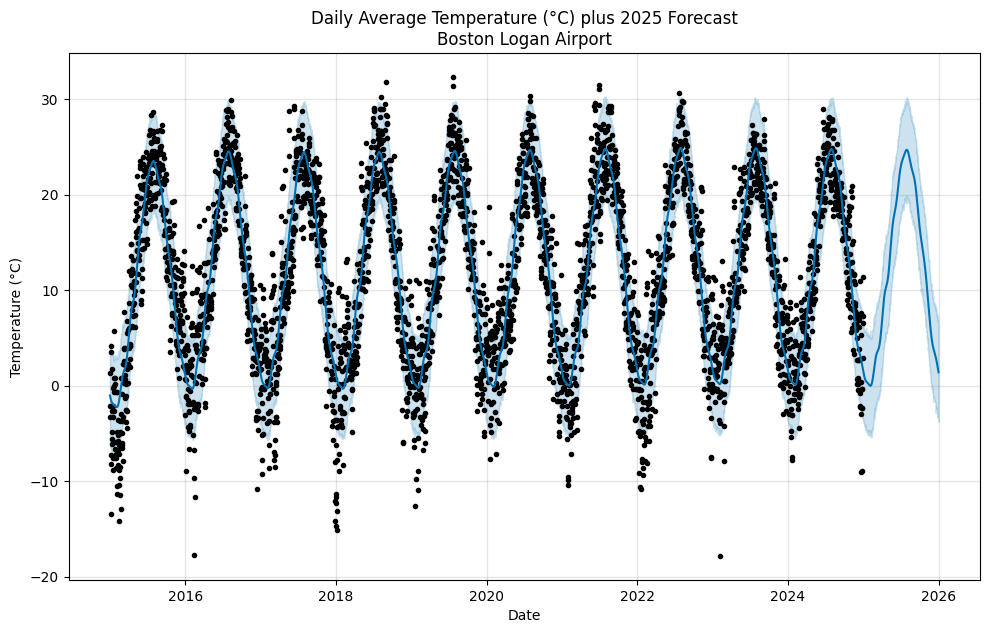

In [ ]:
# https://chatgpt.com/share/6845efdb-f5a4-800c-b03a-442128854276

import logging
import time

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prophet import Prophet

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# ─── Process ─────────────────────────────────────────────────────────────────
df = pd.read_csv("https://github.com/bu-cds-omds/dx704-examples/raw/refs/heads/main/data/boston-temperatures.tsv", sep="\t")
df["ds"] = pd.to_datetime(df["date"]).dt.date
df["y"] = df["temperature"]  # already in °C
df = df.sort_values("ds")

m = Prophet(weekly_seasonality=False)
m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daily Average Temperature (°C) plus 2025 Forecast\nBoston Logan Airport")
plt.show();